# <strong>爬取網站

In [1]:
import requests
from bs4 import BeautifulSoup
headers = {'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36 Edg/80.0.361.48'}
cookies = {'over18': '1'}
url = 'https://www.ptt.cc/bbs/Gossiping/index.html'

res = requests.get(url, headers=headers, cookies=cookies)
res.encoding = 'utf-8'
soup = BeautifulSoup(res.text, 'html.parser')

# <strong>解析網站HTML

In [2]:
datas = []
for article in soup.find_all('div', class_='r-ent'):
    try:
        info = {}
        info['title'] = article.find('div', class_='title').text
        info['author'] = article.find('div', class_='author').text
        url = 'https://www.ptt.cc/' + article.find('a')['href']
        info['url'] = url
        soup2 = BeautifulSoup(requests.get(url, headers=headers, cookies=cookies).text, 'html.parser')
        main_content = soup2.find('div', id='main-content')
        info['pub_time'] = main_content.find_all('span', class_='article-meta-value')[3].text
        for i in main_content.find_all('span', class_='f2'):
            if '來自' in str(i):
                info['author_ip'] = str(i).split('來自: ')[1].split(' (')[0]
        info['content'] = main_content.text.split('2020')[1].split('發信站')[0].strip()
        datas.append(info)
    except:
        pass

## <strong>輸出成DataFrame格式

In [3]:
import pandas as pd

df = pd.DataFrame(datas)
df.head()

,title,author,url,pub_time,author_ip,content
0,\n[問卦] 小明！你給我進來！！\n,sanxiao,https://www.ptt.cc//bbs/Gossiping/M.1581427946...,Tue Feb 11 21:32:24 2020,39.8.62.245,現在是怎樣！？\n\n當我們龍哥被嚇大的？\n\n我們龍哥的地盤，是你想來就來的！？\n\n...
1,\n[問卦] 愛上了一個盲人女孩怎麼辦？\n,zzff92,https://www.ptt.cc//bbs/Gossiping/M.1581427958...,Tue Feb 11 21:32:36 2020,110.50.187.47,本魯接到一個殺人的命令\n說只要殺了目標就可以\n重回組織\n\n結果一路追查到一間按摩館\...
2,\n[問卦] 奈良鹿代是火之國籍還是風之國籍?\n,WolfTeacher,https://www.ptt.cc//bbs/Gossiping/M.1581427960...,Tue Feb 11 21:32:38 2020,180.176.0.145,欸欸\n\n火影裡面的奈良鹿代啦\n\n他爸是火之國木葉忍者村的村長的左右手\n\n他媽是風...
3,\n[新聞] 酒後狂歡還開車！ 高速撞死女騎士判刑8年\n,kiyoe,https://www.ptt.cc//bbs/Gossiping/M.1581427973...,Tue Feb 11 21:32:50 2020,125.231.54.172,1.媒體來源:\n\nTVBS 新聞\n\n2.記者署名\n\n李潔\n\n3.完整新聞標題...
4,\nRe: [問卦] 人道考量無限上綱推演下去會怎樣?\n,cvn21,https://www.ptt.cc//bbs/Gossiping/M.1581427974...,Tue Feb 11 21:32:52 2020,49.216.50.71,本處（府/黨/部/院/會）自行帶入\n本於人道關懷之精神\n認為台獨切實傷害大陸地區十四億同...


# <strong>定義"移除停留字"方法

In [4]:
def remove_stop_words(file_name, seg):
    with open(file_name, 'r', encoding='utf-8') as f:
        stop_words = f.readlines()
    stop_words = [stop_word.strip() for stop_word in stop_words]
    if seg not in stop_words:
        return True

## <strong>定義"計算詞彙出現次數"方法

In [5]:
def count_segment_freq(seg_list):
    seg_df = pd.DataFrame(seg_list, columns=['seg'])
    seg_df['count'] = 1
    sef_freq = seg_df.groupby('seg')['count'].sum().sort_values(ascending=False)
    sef_freq = pd.DataFrame(sef_freq)
    return sef_freq

## <strong>使用jieba斷詞，並利用wordcloud繪出文字雲

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.cache
Loading model cost 0.822 seconds.
Prefix dict has been built successfully.


     count
seg       
龍哥       5
你家       2
面子       1
※        1
先        1
別來       1
告訴       1
咖阿       1
嚇大       1
地盤       1


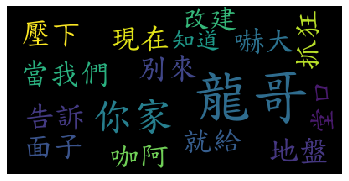

     count
seg       
按摩       3
殺        3
本魯       2
館        1
好像       1
命令       1
卦        1
剛剛       1
一間       1
一路       1


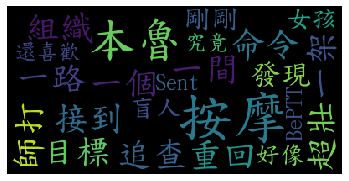

     count
seg       
火之國      2
欸        2
村長       2
村        2
忍者       2
鹿代       1
姐姐       1
U        1
U8       1
※        1


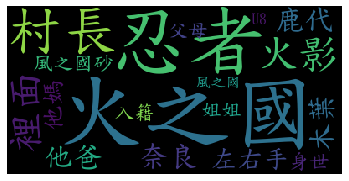

     count
seg       
新聞       3
高速       2
女        2
開車       2
酒後狂      2
記者       2
歡還       2
判刑       2
李潔       2
騎士       2


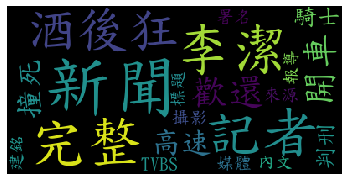

     count
seg       
人民       3
最大       2
人道       2
中華       2
同胞       2
共和       2
）        1
全省       1
兩岸       1
公約數      1


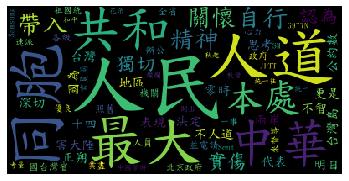

In [6]:
import jieba.analyse
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# 自定義詞典
jieba.load_userdict('word.txt')
# 設定字型
font_path = 'kaiu.ttf'  # 標楷體

for i in range(5):
    seg_list = []
    text = df['content'][i]
    for seg in jieba.cut(text, cut_all=False):
        if remove_stop_words('stop_word.txt', seg) and seg.strip() not in ['\n', '']:
            seg_list.append(seg)
    print(count_segment_freq(seg_list).head(10))
    seg_list = ' '.join(seg_list)
    wc = WordCloud(background_color='black', font_path=font_path)
    wc.generate(seg_list)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()